In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

# クロスバリデーション
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

## オートエンコーダでラベル付与

In [2]:
input_size=10
intermediate_dim=7
latent_dim=4

class AnomalyDetector(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(input_size, activation="relu", input_shape=(window,)),
            layers.Dense(intermediate_dim, activation="relu"),
            layers.Dense(latent_dim, activation="relu")])
        self.decoder = tf.keras.Sequential([
            layers.Dense(intermediate_dim, activation="relu", input_shape=(latent_dim,)),
            layers.Dense(input_size, activation="relu"),
            layers.Dense(window, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

2024/01/04 18:28:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/04 18:28:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/01/04 18:28:13 INFO mlflow.tracking.fluent: Experiment with name 'CV' does not exist. Creating a new experiment.
2024/01/04 18:28:13 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a pri

訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目


2024/01/04 18:28:16 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/04 18:28:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
7662/7662 [==============================] - 32s 4ms/step - loss: 0.0203 - val_loss: 0.0072
Epoch 2/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 3/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 4/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 5/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 6/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 7/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 8/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 9/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 10/100
7662/7662 [==============================] - 30s 4m

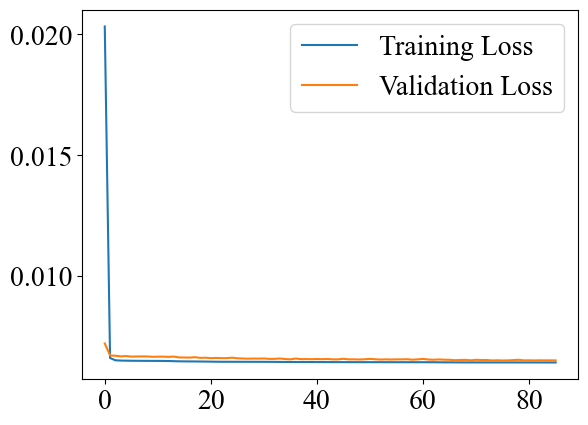

13500/13500 [==============================] - 15s 1ms/step
------------------------------------------------------


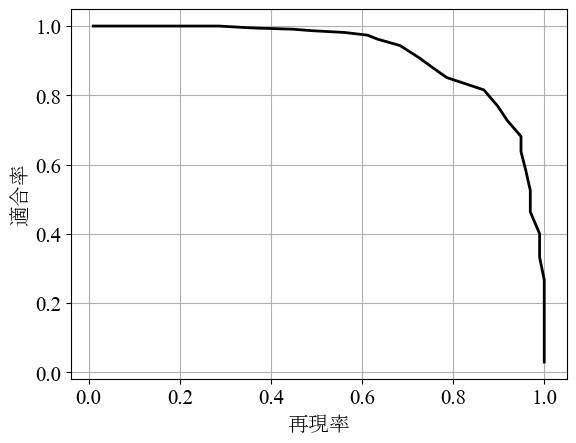

AUC：0.9114437986290718
理想の閾値：0.2615384615384615
F値（最高）：0.8407376723139793
適合率（F値が最高の時）：0.8157124947764313
再現率（F値が最高の時）：0.8673469387755102
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目


2024/01/04 19:13:43 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector_1" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/04 19:13:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
8226/8226 [==============================] - 32s 4ms/step - loss: 0.0125 - val_loss: 0.0079
Epoch 2/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 3/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0061 - val_loss: 0.0078
Epoch 4/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 5/100
8226/8226 [==============================] - 30s 4ms/step - loss: 0.0055 - val_loss: 0.0066
Epoch 6/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 7/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 8/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 9/100
8226/8226 [==============================] - 31s 4ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 10/100
8226/8226 [==============================] - 30s 4m

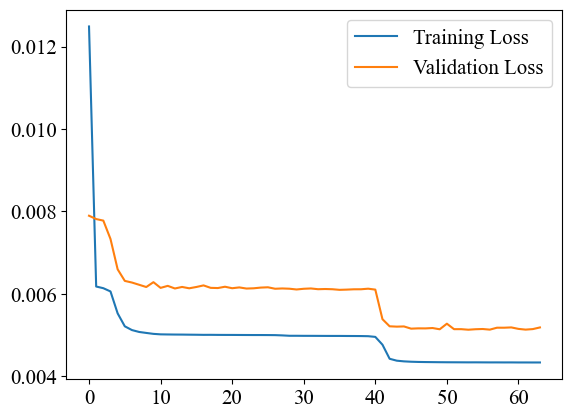

8984/8984 [==============================] - 11s 1ms/step
------------------------------------------------------


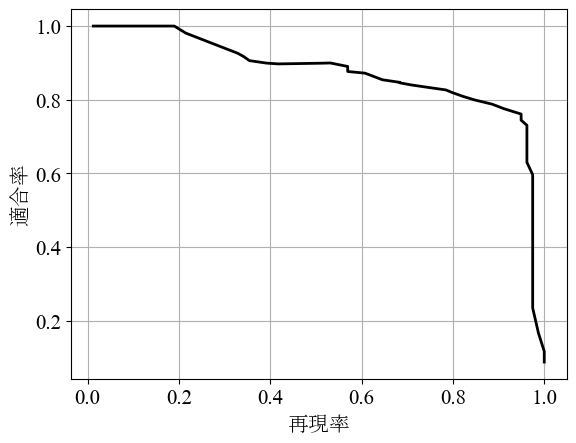

AUC：0.8622867510593268
理想の閾値：0.2769230769230769
F値（最高）：0.8448380912752077
適合率（F値が最高の時）：0.7610441767068273
再現率（F値が最高の時）：0.9493670886075949
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目


2024/01/04 19:49:05 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector_2" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/04 19:49:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
7662/7662 [==============================] - 31s 4ms/step - loss: 0.0266 - val_loss: 0.0121
Epoch 2/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 3/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 4/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 5/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 6/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 7/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 8/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 9/100
7662/7662 [==============================] - 30s 4ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 10/100
7662/7662 [==============================] - 30s 4m

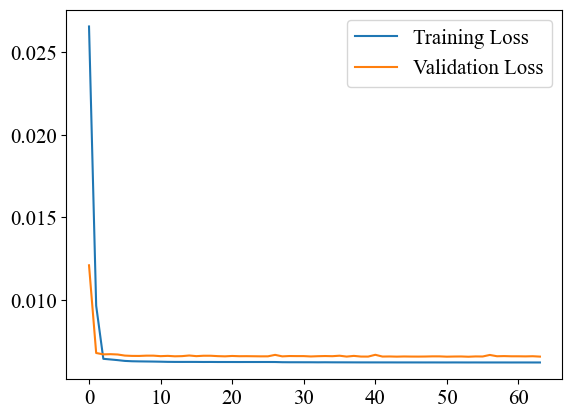

13500/13500 [==============================] - 16s 1ms/step
------------------------------------------------------


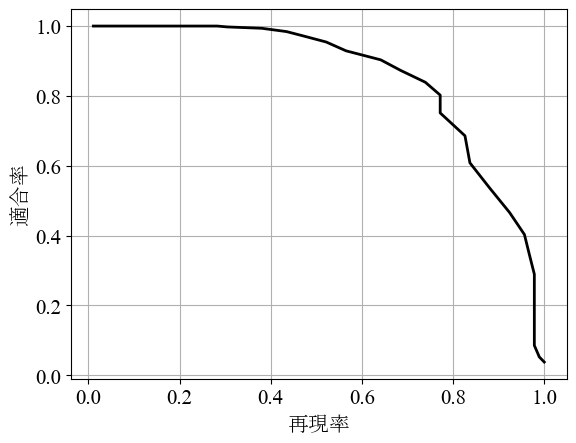

AUC：0.8454720211012156
理想の閾値：0.23076923076923075
F値（最高）：0.7867259758136995
適合率（F値が最高の時）：0.8023064250411862
再現率（F値が最高の時）：0.7717391304347826
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目


2024/01/04 20:24:20 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector_3" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/04 20:24:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
7873/7873 [==============================] - 32s 4ms/step - loss: 0.0127 - val_loss: 0.0055
Epoch 2/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 3/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 4/100
7873/7873 [==============================] - 35s 4ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 5/100
7873/7873 [==============================] - 30s 4ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 6/100
7873/7873 [==============================] - 30s 4ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 7/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 8/100
7873/7873 [==============================] - 31s 4ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 9/100
7873/7873 [==============================] - 30s 4ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 10/100
7873/7873 [==============================] - 30s 4m

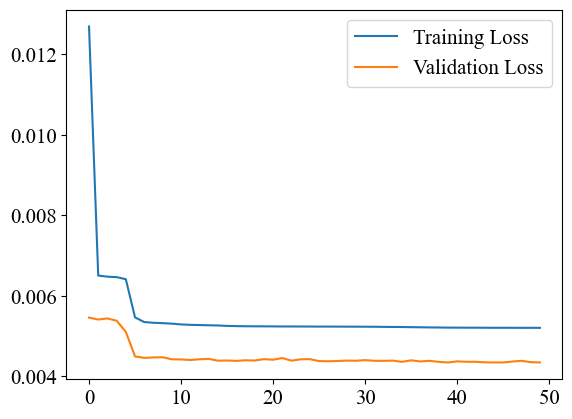

11812/11812 [==============================] - 14s 1ms/step
------------------------------------------------------


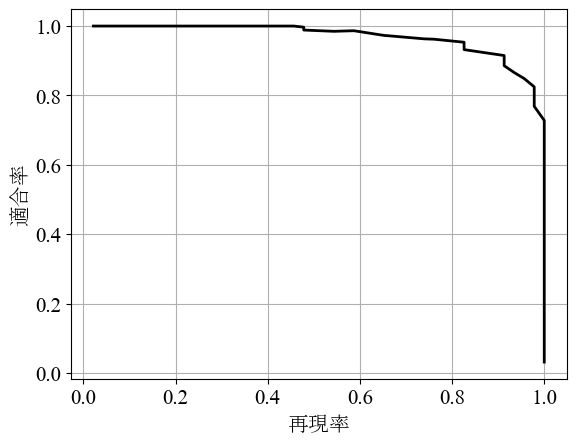

AUC：0.9475905843125265
理想の閾値：0.32307692307692304
F値（最高）：0.9140320485058467
適合率（F値が最高の時）：0.9150227617602428
再現率（F値が最高の時）：0.9130434782608695
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目


2024/01/04 20:52:21 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector_4" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/04 20:52:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
7662/7662 [==============================] - 119s 15ms/step - loss: 0.0165 - val_loss: 0.0066
Epoch 2/100
7662/7662 [==============================] - 114s 15ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 3/100
7662/7662 [==============================] - 66s 9ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 4/100
7662/7662 [==============================] - 115s 15ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 5/100
7662/7662 [==============================] - 84s 11ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 6/100
7662/7662 [==============================] - 103s 14ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 7/100
7662/7662 [==============================] - 110s 14ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 8/100
7662/7662 [==============================] - 109s 14ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 9/100
7662/7662 [==============================] - 110s 14ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 10/100
7662/7662 [=========================

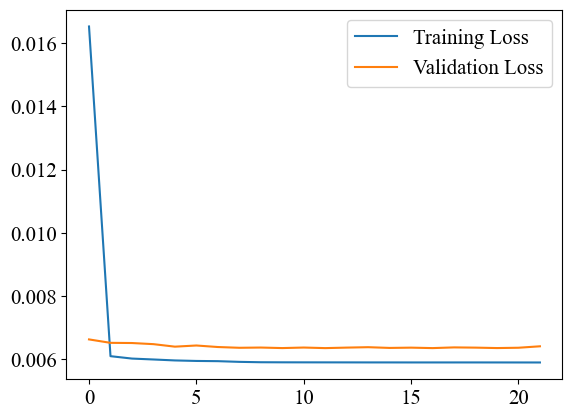

13499/13499 [==============================] - 57s 4ms/step
------------------------------------------------------


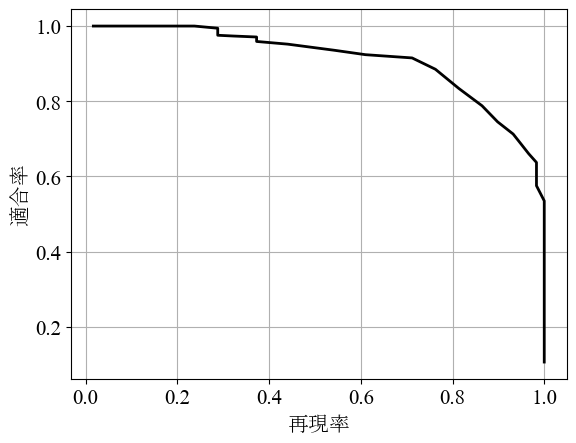

AUC：0.8959108630107665
理想の閾値：0.1846153846153846
F値（最高）：0.8244237149470275
適合率（F値が最高の時）：0.7879759519038076
再現率（F値が最高の時）：0.864406779661017
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目


2024/01/04 21:35:25 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "anomaly_detector_5" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/01/04 21:35:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/100
7662/7662 [==============================] - 114s 14ms/step - loss: 0.0186 - val_loss: 0.0119
Epoch 2/100
7662/7662 [==============================] - 110s 14ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 3/100
7662/7662 [==============================] - 114s 15ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 4/100
7662/7662 [==============================] - 112s 15ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 5/100
7662/7662 [==============================] - 112s 15ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 6/100
7662/7662 [==============================] - 112s 15ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 7/100
7662/7662 [==============================] - 111s 15ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 8/100
7662/7662 [==============================] - 115s 15ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 9/100
7662/7662 [==============================] - 111s 14ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 10/100
7662/7662 [======================

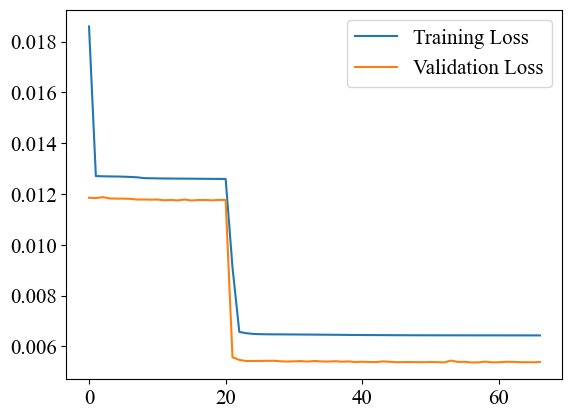

13500/13500 [==============================] - 16s 1ms/step
------------------------------------------------------


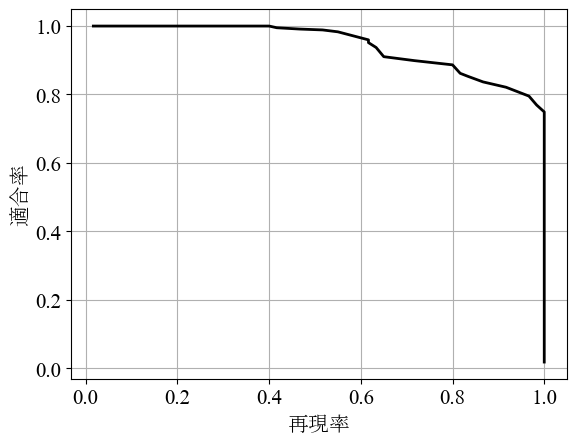

AUC：0.9271634109588484
理想の閾値：0.3538461538461538
F値（最高）：0.8726453284395748
適合率（F値が最高の時）：0.7952924393723253
再現率（F値が最高の時）：0.9666666666666667
=============CV_AUC_mean===============
0.8983112381786259


In [3]:
# remote_server_uri = "http://localhost:5000"  # set to your server URI
# mlflow.set_tracking_uri(remote_server_uri)
mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("CV")
run_name='result'
with mlflow.start_run(run_name=run_name):
    test_day=[6, 7, 8, 9]
    semi_train_day=[0, 1, 2, 3, 4, 5]
    mlflow.log_params({'CV_day':semi_train_day})
    auc_list=[]
    for day in semi_train_day:
        data_dir='filtered_csv_label'
        original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
        df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
        df=df[df['day']<=9]

        test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
        semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)
        
        df_list=[]
        window=15
        for i in set(df['day']):
            lag=[] 
            lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
            lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
            lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
            df_add_lag=pd.concat(lag, axis=1)
            df_list.append(df_add_lag)
        semi_train_df=pd.concat(df_list)
        semi_train_df=semi_train_df.dropna().reset_index(drop=True)
        semi_train_df.loc[:, 'aed']=0
        semi_train_df.loc[:, 'aed_label']=0
        
        # テストデータとする日
        i=[day]
        label_train_day=[k for k in semi_train_day if k not in i]
        label_grant_day=i
        print(f'訓練データ：{label_train_day}')
        print(f'ラベル付与データ：{label_grant_day}日目')
       
        semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        # tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
        # min_valにはtrain_data内の最小値が代入されます。
        min_val = tf.reduce_min(semi_train_x)
        # tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
        # max_valにはtrain_data内の最大値が代入されます。
        max_val = tf.reduce_max(semi_train_x)
        train_data = (semi_train_x.values - min_val) / (max_val - min_val)
        labeling_data = (labeling_x.values - min_val) / (max_val - min_val)
        # データの型をtf.float32に変換
        train_data = tf.cast(train_data, tf.float32)

        labeling_data = tf.cast(labeling_data, tf.float32)
        autoencoder = AnomalyDetector()
        autoencoder.compile(optimizer='adam', loss='mae')

        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            restore_best_weights=True
        )
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = autoencoder.fit(train_data, train_data, 
              epochs=100, 
              batch_size=256,
              validation_data=(labeling_data, labeling_data),
              callbacks=[callback, tensorboard_callback],
              shuffle=True)

        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

        reconstructions = autoencoder.predict(labeling_data)
        #     異常度算出
        d= tf.keras.losses.mae(reconstructions, labeling_data).numpy()
        semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'aed']=d
        print('------------------------------------------------------')

        test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
        d_test=(d-d.min())/(d.max()-d.min())

        thr_bins=50
        p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
        f_max=f_score.max()
        p_max=p_score[np.argmax(f_score)]
        r_max=r_score[np.argmax(f_score)]
        print('\033[31m'+f'AUC：{auc}'+'\033[0m')
        print(f'理想の閾値：{thr}')
        print(f'F値（最高）：{f_max}')
        print(f'適合率（F値が最高の時）：{p_max}')
        print(f'再現率（F値が最高の時）：{r_max}')
        auc_list.append(auc)

    #平均
    auc_mean=np.mean(auc_list)
    # Log the loss metric
    mlflow.log_metric("CV_test_AUC", auc_mean)
    print('=============CV_AUC_mean===============')
    print(auc_mean)

## 訓練データとテストデータの重複を確認

In [11]:
semi_train_x.drop_duplicates()

,original,original_lag1,original_lag2,original_lag3,original_lag4,original_lag5,original_lag6,original_lag7,original_lag8,original_lag9,original_lag10,original_lag11,original_lag12,original_lag13,original_lag14
0,54.9,55.0,55.7,55.8,55.6,55.7,55.5,55.7,54.7,54.0,53.6,53.2,52.8,52.8,53.4
1,54.9,54.9,55.0,55.7,55.8,55.6,55.7,55.5,55.7,54.7,54.0,53.6,53.2,52.8,52.8
2,54.9,54.9,54.9,55.0,55.7,55.8,55.6,55.7,55.5,55.7,54.7,54.0,53.6,53.2,52.8
3,55.0,54.9,54.9,54.9,55.0,55.7,55.8,55.6,55.7,55.5,55.7,54.7,54.0,53.6,53.2
4,55.0,55.0,54.9,54.9,54.9,55.0,55.7,55.8,55.6,55.7,55.5,55.7,54.7,54.0,53.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961350,45.1,45.2,45.0,45.8,45.8,46.1,46.2,45.6,45.9,45.3,45.2,45.5,45.5,45.4,45.0
1961351,45.1,45.1,45.2,45.0,45.8,45.8,46.1,46.2,45.6,45.9,45.3,45.2,45.5,45.5,45.4
1961352,45.2,45.1,45.1,45.2,45.0,45.8,45.8,46.1,46.2,45.6,45.9,45.3,45.2,45.5,45.5
1961353,45.3,45.2,45.1,45.1,45.2,45.0,45.8,45.8,46.1,46.2,45.6,45.9,45.3,45.2,45.5


In [12]:
labeling_x.drop_duplicates()

,original,original_lag1,original_lag2,original_lag3,original_lag4,original_lag5,original_lag6,original_lag7,original_lag8,original_lag9,original_lag10,original_lag11,original_lag12,original_lag13,original_lag14
0,55.5,54.7,54.5,53.0,52.0,50.5,49.7,49.0,48.4,47.8,47.9,47.8,47.4,47.2,46.9
1,55.0,55.5,54.7,54.5,53.0,52.0,50.5,49.7,49.0,48.4,47.8,47.9,47.8,47.4,47.2
2,55.7,55.0,55.5,54.7,54.5,53.0,52.0,50.5,49.7,49.0,48.4,47.8,47.9,47.8,47.4
3,55.7,55.7,55.0,55.5,54.7,54.5,53.0,52.0,50.5,49.7,49.0,48.4,47.8,47.9,47.8
4,56.0,55.7,55.7,55.0,55.5,54.7,54.5,53.0,52.0,50.5,49.7,49.0,48.4,47.8,47.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431966,45.0,45.4,45.1,44.8,45.4,45.6,45.0,45.7,45.1,44.9,44.9,45.2,44.6,45.0,45.2
431967,45.2,45.0,45.4,45.1,44.8,45.4,45.6,45.0,45.7,45.1,44.9,44.9,45.2,44.6,45.0
431968,45.1,45.2,45.0,45.4,45.1,44.8,45.4,45.6,45.0,45.7,45.1,44.9,44.9,45.2,44.6
431969,45.1,45.1,45.2,45.0,45.4,45.1,44.8,45.4,45.6,45.0,45.7,45.1,44.9,44.9,45.2


In [13]:
duplicates = pd.merge(semi_train_x.drop_duplicates(), labeling_x.drop_duplicates(), how='inner')
duplicates

,original,original_lag1,original_lag2,original_lag3,original_lag4,original_lag5,original_lag6,original_lag7,original_lag8,original_lag9,original_lag10,original_lag11,original_lag12,original_lag13,original_lag14


In [4]:
# Mlflow UI上で削除してもマシン上に実態は残っている
# 残ったデータを完全に削除する
! mlflow gc --backend-store-uri ./mlruns

In [1]:
! mlflow ui --port 5002 

^C


In [10]:
auc_list

[0.9114437986290718,
 0.8622867510593268,
 0.8454720211012156,
 0.9475905843125265,
 0.8959108630107665,
 0.9271634109588484]